In [ ]:
# Set to True to export results
params_export_flag = False

# Set to true to include timestamp in output directory name
params_export_timestamp = False

# String for a filepath to a config file mapping file identifiers to filepaths.
input_config_filepaths = None

# Parent directory for output files.
output_directory = "../results/"

# Figure - comparative genomics - mappability of peaks called in human and mouse

## Overview

Quantify the overlaps between peaks called in human and mouse after coordinate lift-over.

## Imports

In [24]:
import datetime
from pathlib import Path
import pandas as pd
import collections
from typing import Literal
import os
import sys
import yaml

from dataclasses import dataclass
import pandera

In [48]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns
from matplotlib import rc

try:
    matplotlib.font_manager.findfont("Arial")
    mpl.rcParams["font.sans-serif"] = ["Arial"]
except Exception as e:
    print(f"Arial font not found: {e}")
    mpl.rcParams["font.sans-serif"] = ["DejaVu Sans"]

rc("text", usetex=False)

## Initialization

In [ ]:
if params_export_flag:
    if params_export_timestamp:
        timestamp_format = "%Y-%m-%d"

        outputdir = Path(output_directory) / f"mappability.{datetime.datetime.now().strftime(timestamp_format)}"
    else:
        outputdir = Path(output_directory) / "mappability"

    if not outputdir.exists():
        outputdir.mkdir(parents=True)

    print(outputdir)

In [ ]:
if input_config_filepaths is not None:
    if Path(input_config_filepaths).exists():
        with open(input_config_filepaths, "r") as f:
            filepaths = yaml.safe_load(f)
    else:
        filepaths = {}

# NOTE: hard-coded filepaths override config filepaths if defined
local_filepaths = {
    "supp_table_binding_sites": None,
    "mouse_3utr_bs_mappability": None,
    "human_3utr_bs_mappability": None,
}

filepaths = {
    **{k: v for k, v in local_filepaths.items() if v is not None},
    **local_filepaths,
}

## Load

In [59]:
class SchemaBindingSiteMappabilityStatus(pandera.DataFrameModel):
    identifier: pandera.Column(str, coerce=True, required=True)
    status: pandera.Column(
        str,
        coerce=True,
        required=True,
        checks=pandera.Check.isin(
            [
                "aligned_bound-ortholog_distant",
                "aligned_bound-ortholog_matched",
                "aligned_species-specific",
                "not-aligned_bound-ortholog",
                "not-aligned_species-specific",
            ]
        ),
    )


class SchemaBindingSiteMappabilityStatus(pandera.DataFrameModel):
    identifier: pandera.typing.Series[str] = pandera.Field(coerce=True)
    status: pandera.typing.Series[str] = pandera.Field(
        coerce=True,
        isin=[
            "aligned_bound-ortholog_distant",
            "aligned_bound-ortholog_matched",
            "aligned_species-specific",
            "not-aligned_bound-ortholog",
            "not-aligned_species-specific",
        ],
    )


def load_function(
    species: Literal["mouse", "human"],
    load_from: Literal["supp_table_excel", "tsv"],
    filepaths: dict[str, os.PathLike],
) -> SchemaBindingSiteMappabilityStatus:
    """Load function."""

    if load_from == "supp_table_excel":
        filepath = filepaths["supp_table_binding_sites"]

        if species == "mouse":
            sheet_name = "08_mouse_3UTR_peaks"

        elif species == "human":
            sheet_name = "07_human_3UTR_peaks"
        else:
            raise ValueError("Invalid species. Use 'mouse' or 'human'.")

        df = pd.read_excel(
            filepath,
            sheet_name=sheet_name,
            header=0,
            index_col=0,
        )

    elif load_from == "tsv":
        if species == "mouse":
            filepath = filepaths["mouse_3utr_bs_mappability"]

        elif species == "human":
            filepath = filepaths["human_3utr_bs_mappability"]
        else:
            raise ValueError("Invalid species. Use 'mouse' or 'human'.")

        df = pd.read_csv(filepath, sep="\t", header=0, index_col=None)
    else:
        raise ValueError("Invalid load_from value. Use 'supp_table' or 'tsv'.")

    # Validate the dataframe against the schema
    return SchemaBindingSiteMappabilityStatus.validate(df)

In [60]:
h_peaks_orthology_label_3utr = load_function(
    species="human",
    load_from="supp_table_excel",
    filepaths=filepaths,
)

display(h_peaks_orthology_label_3utr.head())
display(h_peaks_orthology_label_3utr.shape)

m_peaks_orthology_label_3utr = load_function(
    species="mouse",
    load_from="supp_table_excel",
    filepaths=filepaths,
)

display(m_peaks_orthology_label_3utr.head())
display(m_peaks_orthology_label_3utr.shape)


,identifier,status
0,chr1:23961916-23961925:+,not-aligned_bound-ortholog
1,chr1:23961935-23961944:+,not-aligned_bound-ortholog
2,chr1:23962508-23962517:+,not-aligned_bound-ortholog
3,chr1:23962518-23962527:+,not-aligned_bound-ortholog
4,chr1:23963013-23963022:+,not-aligned_bound-ortholog


(22338, 2)

,identifier,status
0,chr1:36526658-36526667:+,not-aligned_bound-ortholog
1,chr1:36526988-36526997:+,not-aligned_bound-ortholog
2,chr1:36527018-36527027:+,not-aligned_bound-ortholog
3,chr1:52187483-52187492:-,not-aligned_bound-ortholog
4,chr1:60999973-60999982:+,not-aligned_bound-ortholog


(12565, 2)

## Plot

In [ ]:
# SIMPLIFIED CATEGORIES:
# The "not-aligned_bound-ortholog" can be simplified to "aligned_bound-ortholog_distant"
# The "not-aligned_species-specific" can be simplified to "aligned_species-specific"


simplify_status_mapping = {
    "not-aligned_bound-ortholog": "aligned_bound-ortholog_distant",
    "not-aligned_species-specific": "aligned_species-specific",
}


m_peaks_orthology_label_3utr["simplified_status"] = m_peaks_orthology_label_3utr["status"].replace(
    simplify_status_mapping
)

h_peaks_orthology_label_3utr["simplified_status"] = h_peaks_orthology_label_3utr["status"].replace(
    simplify_status_mapping
)

In [ ]:
counts_peaks_orthology_label_3utr = (
    pd.concat(
        [
            m_peaks_orthology_label_3utr.assign(status=lambda df: "mouse." + df["simplified_status"])[
                "status"
            ].value_counts(),
            h_peaks_orthology_label_3utr.assign(status=lambda df: "human." + df["simplified_status"])[
                "status"
            ].value_counts(),
        ],
        axis=0,
    )
    .fillna(0)
    .astype(int)
    .rename("count")
)

display(counts_peaks_orthology_label_3utr)

mouse.aligned_bound-ortholog_distant    6237
mouse.aligned_species-specific          3169
mouse.aligned_bound-ortholog_matched    3159
human.aligned_species-specific          9674
human.aligned_bound-ortholog_distant    9422
human.aligned_bound-ortholog_matched    3242
Name: count, dtype: int64

In [44]:
PEAKS_COUNTS_ORDERED_LABELS = [
    "mouse.not-aligned_species-specific",
    "mouse.aligned_species-specific",
    "mouse.not-aligned_bound-ortholog",
    #
    "mouse.aligned_bound-ortholog_distant",
    #
    "mouse.aligned_bound-ortholog_matched",
    "human.aligned_bound-ortholog_matched",
    #
    "human.aligned_bound-ortholog_distant",
    #
    "human.aligned_species-specific",
    "human.not-aligned_bound-ortholog",
    "human.not-aligned_species-specific",
]

for c in counts_peaks_orthology_label_3utr.index.values:
    if c not in PEAKS_COUNTS_ORDERED_LABELS:
        print(c)
        raise ValueError()


In [ ]:
tmp = counts_peaks_orthology_label_3utr.to_frame().reset_index()

# Add "species-specific" hue column
tmp["is_ortholog_bound"] = ~tmp["index"].str.contains("species-specific")


palette_is_orth_bound = {
    True: "#666666",
    False: "#BBBBBB",
}

# Build a palette from the names of the status basing on the "is_ortholog_bound" column
palette = {
    k: palette_is_orth_bound[is_ortholog_bound] for k, is_ortholog_bound in zip(tmp["index"], tmp["is_ortholog_bound"])
}

# Simplify the labels : clear distinction between orthologous gene being bound or not +
# if orthologs are bound, whether the lift-over coordinates match or not.
renaming_dict = {
    "mouse.aligned_species-specific": "Mouse-only\nbinding",
    "human.aligned_species-specific": "Human-only\nbinding",
    "mouse.aligned_bound-ortholog_matched": "Matching coordinates",
    "mouse.aligned_bound-ortholog_distant": "Different\ncoordinates",
    "human.aligned_bound-ortholog_matched": "Matching coordinates",
    "human.aligned_bound-ortholog_distant": "Different\ncoordinates",
}

display(tmp)


PEAKS_COUNTS_ORDERED_LABELS = [label for label in PEAKS_COUNTS_ORDERED_LABELS if label in tmp["index"].values]

,index,count,is_ortholog_bound
0,mouse.aligned_bound-ortholog_distant,6237,True
1,mouse.aligned_species-specific,3169,False
2,mouse.aligned_bound-ortholog_matched,3159,True
3,human.aligned_species-specific,9674,False
4,human.aligned_bound-ortholog_distant,9422,True
5,human.aligned_bound-ortholog_matched,3242,True


In [57]:
# New palette to make colorful distinction between orthologous binding statuses.

new_palette = {
    "mouse.aligned_species-specific": "#ED7FEE",  # Pink
    #
    "mouse.aligned_bound-ortholog_distant": "#F8A350",  # Orange
    #
    "mouse.aligned_bound-ortholog_matched": "#277141",  # Green
    "human.aligned_bound-ortholog_matched": "#277141",  # Green
    #
    "human.aligned_bound-ortholog_distant": "#F8A350",  # Orange
    #
    "human.aligned_species-specific": "#3341FF",  # Dark blue
}

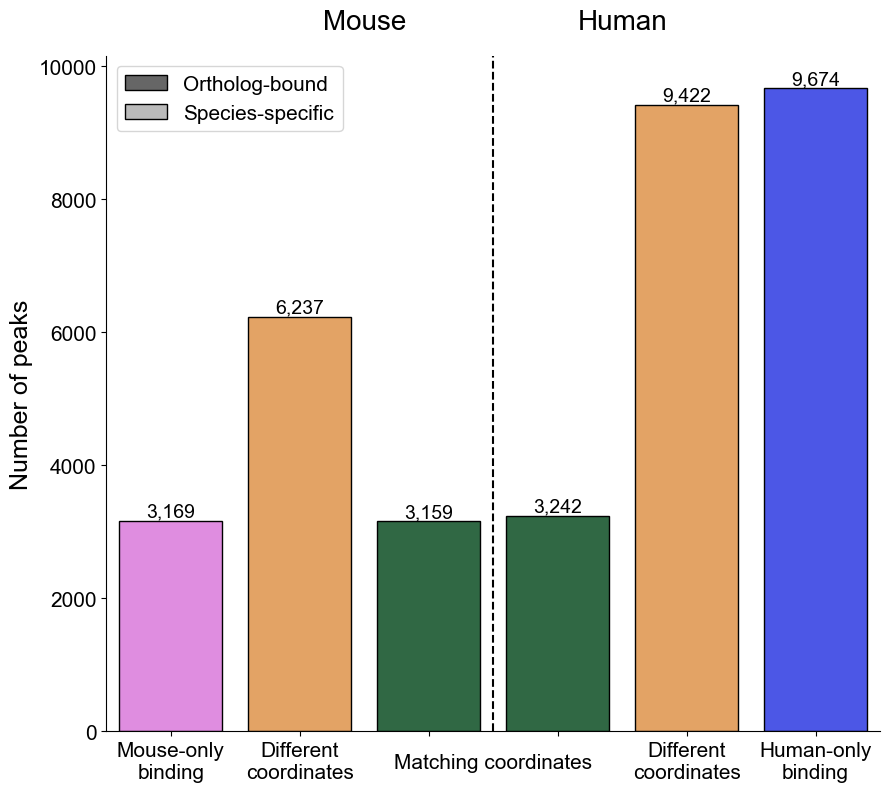

In [ ]:
fig = plt.figure(figsize=(9, 8))
ax1 = fig.add_subplot(1, 1, 1)

sns.barplot(
    data=tmp,
    x="index",
    y="count",
    order=PEAKS_COUNTS_ORDERED_LABELS,
    palette=new_palette,
    edgecolor="black",
    linewidth=1.0,
    ax=ax1,
)

_ = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")
_ = ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=15)

ax1.set_xlabel("")
ax1.set_ylabel("Count")

# Add the numbers above each bar in the plot
for p in ax1.patches:
    ax1.annotate(
        f"{int(p.get_height()):,}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        color="black",
        size=14,
    )

ax1.set_ylabel("Number of peaks", fontsize=18)
ax1.set_xlabel("", fontsize=18)

# Remove upper and right spines
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


# Rename the xticks
ax1.set_xticklabels(
    [
        renaming_dict[label.get_text()] if renaming_dict[label.get_text()] != "Matching coordinates" else ""
        for label in ax1.get_xticklabels()
    ],
    rotation=0,
    ha="center",
    fontsize=15,
)

# Manually add a text for the "Matching coordinates" category
ax1.text(
    2.5,
    0,
    "\nMatching coordinates",
    ha="center",
    va="top",
    fontsize=15,
    color="black",
    # Add vertical space between the text and the bottom spine of the plot
    transform=ax1.transData,
)


# add vertical line in the middle of the plot
ax1.axvline(2.5, color="black", lw=1.5, ls="--")

# Add text labels "Mouse" and "Human" on the left and right side of the plot
ax1.text(
    1.5,
    ax1.get_ylim()[1] * 1.05,
    "Mouse",
    ha="center",
    va="center",
    fontsize=20,
    color="black",
)
ax1.text(
    3.5,
    ax1.get_ylim()[1] * 1.05,
    "Human",
    ha="center",
    va="center",
    fontsize=20,
    color="black",
)


# Add legend for the colors
# Use the "is_ortholog_bound" status
legend_elements = [
    mpatches.Patch(facecolor=palette_is_orth_bound[True], edgecolor="black", label="Ortholog-bound"),
    mpatches.Patch(
        facecolor=palette_is_orth_bound[False],
        edgecolor="black",
        label="Species-specific",
    ),
]


plt.legend(handles=legend_elements, loc="upper left", fontsize=15)

plt.tight_layout()

if params_export_flag:
    for ext in [".png", ".pdf", ".svg"]:
        filepath = outputdir / f"cross_species_mappability.barplot.{ext}"
        print(f"Saving figure to {filepath}")
        plt.savefig(filepath, bbox_inches="tight", dpi=300)